In [17]:
from qdrant_client import QdrantClient
from sentence_transformers import SentenceTransformer
import numpy as np
from pathlib import Path
import pickle
from tqdm import tqdm
import gc
from typing import List, Dict, Tuple, Set
from urllib.parse import unquote, quote
import re
from rapidfuzz import fuzz
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import torch
import pandas as pd

# Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️  Using device: {device}")

# Connect to Qdrant
client = QdrantClient(host="localhost", port=6333, prefer_grpc=True)
print("✅ Connected to Qdrant")

# Load model
model = SentenceTransformer("intfloat/multilingual-e5-large", device=device)
print("✅ Embedding model loaded")

# Configuration
COLLECTION_NAME = "wikipedia_fr"
PARQUET_PATH = "articles_fr_merged.parquet"
MAPPING_CACHE_PATH = "url_to_id_mapping.pkl"
ANCHOR_DICT_CACHE = "anchor_dictionary.pkl"

🖥️  Using device: cuda
✅ Connected to Qdrant
✅ Embedding model loaded


In [18]:
def create_url_to_id_mapping_from_qdrant(
    client,
    collection_name: str = "wikipedia_fr",
    cache_path: str = "url_to_id_mapping.pkl"
) -> Tuple[Dict[str, int], Dict[int, str]]:
    """Build URL → ID mapping with caching."""
    cache_file = Path(cache_path)
    
    if cache_file.exists():
        print(f"📂 Loading URL mapping from cache: {cache_path}")
        with open(cache_file, 'rb') as f:
            cached_data = pickle.load(f)
        print(f"✅ Loaded {len(cached_data['url_to_id']):,} URL mappings from cache")
        return cached_data['url_to_id'], cached_data['id_to_title']
    
    print(f"🗺️  Building URL → ID mapping from '{collection_name}'...")
    
    url_to_id = {}
    id_to_title = {}
    
    offset = None
    batch_size = 1000
    total_processed = 0
    
    with tqdm(desc="Processing articles") as pbar:
        while True:
            points, offset = client.scroll(
                collection_name=collection_name,
                limit=batch_size,
                offset=offset,
                with_payload=True,
                with_vectors=False
            )
            
            if not points:
                break
            
            for point in points:
                article_id = point.payload.get("id")
                title = point.payload.get("title", "")
                
                if not article_id or not title:
                    continue
                
                id_to_title[article_id] = title
                
                patterns = [
                    title,
                    title.replace(" ", "_"),
                    quote(title.replace(" ", "_"), safe=""),
                    title.lower(),
                    title.lower().replace(" ", "_"),
                    title.lower().replace(" ", "%20"),
                ]
                
                for pattern in patterns:
                    url_to_id[pattern] = article_id
            
            total_processed += len(points)
            pbar.update(len(points))
            
            if offset is None:
                break
    
    print(f"✅ Created {len(url_to_id):,} URL mappings from {total_processed:,} articles")
    
    cache_data = {
        'url_to_id': url_to_id,
        'id_to_title': id_to_title
    }
    with open(cache_file, 'wb') as f:
        pickle.dump(cache_data, f)
    print("✅ Cache saved")
    
    return url_to_id, id_to_title

# Build or load mappings
url_to_id, id_to_title = create_url_to_id_mapping_from_qdrant(
    client, 
    COLLECTION_NAME,
    MAPPING_CACHE_PATH
)

📂 Loading URL mapping from cache: url_to_id_mapping.pkl
✅ Loaded 12,682,763 URL mappings from cache


In [19]:
def build_anchor_dictionary(
    parquet_path: str,
    cache_path: str = "anchor_dictionary.pkl"
) -> Dict[str, Dict[int, int]]:
    """Build anchor text → article ID dictionary with counts."""
    cache_file = Path(cache_path)
    
    if cache_file.exists():
        print(f"📂 Loading anchor dictionary from cache: {cache_path}")
        with open(cache_file, 'rb') as f:
            anchor_dict = pickle.load(f)
        print(f"✅ Loaded anchor dictionary with {len(anchor_dict):,} unique anchors")
        return anchor_dict
    
    print("🔨 Building anchor text dictionary from Wikipedia links...")
    
    anchor_dict = defaultdict(lambda: defaultdict(int))
    
    lf = pl.scan_parquet(parquet_path).filter(
        pl.col('link_count') > 0
    ).select(['links'])
    
    offset = 0
    batch_size = 1000
    
    with tqdm(desc="Processing links") as pbar:
        while True:
            batch = lf.slice(offset, batch_size).collect(streaming=True)
            
            if batch.height == 0:
                break
            
            for row in batch.iter_rows(named=True):
                links_raw = row.get("links", [])
                if links_raw is None:
                    continue
                
                links = list(links_raw) if hasattr(links_raw, "__iter__") else []
                
                for link in links:
                    anchor = link.get('anchor', '').strip()
                    href = link.get('href_decoded', '')
                    
                    if not anchor or not href:
                        continue
                    
                    anchor_norm = anchor.lower()
                    
                    target_id = url_to_id.get(href)
                    if not target_id:
                        for variation in [
                            href.replace("_", " "),
                            href.replace("%20", " "),
                            href.lower(),
                        ]:
                            target_id = url_to_id.get(variation)
                            if target_id:
                                break
                    
                    if target_id:
                        anchor_dict[anchor_norm][target_id] += 1
            
            offset += batch_size
            pbar.update(batch_size)
    
    # Convert to regular dict
    anchor_dict = {k: dict(v) for k, v in anchor_dict.items()}
    
    print(f"✅ Built anchor dictionary with {len(anchor_dict):,} unique anchors")
    
    with open(cache_file, 'wb') as f:
        pickle.dump(anchor_dict, f)
    print("✅ Anchor dictionary saved")
    
    return anchor_dict

# Build anchor dictionary
anchor_dict = build_anchor_dictionary(PARQUET_PATH, ANCHOR_DICT_CACHE)

📂 Loading anchor dictionary from cache: anchor_dictionary.pkl
✅ Loaded anchor dictionary with 3,292,251 unique anchors


In [20]:
# Compute anchor frequency statistics for filtering common terms
def compute_anchor_statistics(anchor_dict: Dict[str, Dict[int, int]]) -> Dict:
    """Compute statistics about anchor usage."""
    total_anchors = len(anchor_dict)
    anchor_frequencies = {}
    
    for anchor, targets in anchor_dict.items():
        total_count = sum(targets.values())
        anchor_frequencies[anchor] = total_count
    
    # Sort by frequency
    sorted_anchors = sorted(anchor_frequencies.items(), key=lambda x: x[1], reverse=True)
    
    # Top 1% are very common terms (likely too general to link)
    top_1_percent_threshold = sorted_anchors[int(0.01 * len(sorted_anchors))][1] if sorted_anchors else 0
    
    print(f"\n📊 Anchor Statistics:")
    print(f"   Total unique anchors: {total_anchors:,}")
    print(f"   Top 1% threshold (very common): {top_1_percent_threshold:,} occurrences")
    print(f"   Top 10 most common anchors:")
    for anchor, count in sorted_anchors[:10]:
        print(f"      '{anchor}': {count:,}")
    
    return {
        'anchor_frequencies': anchor_frequencies,
        'common_term_threshold': top_1_percent_threshold
    }

anchor_stats = compute_anchor_statistics(anchor_dict)


📊 Anchor Statistics:
   Total unique anchors: 3,292,251
   Top 1% threshold (very common): 172 occurrences
   Top 10 most common anchors:
      'états-unis': 174,457
      'france': 139,763
      'paris': 136,202
      'espèce': 131,548
      'famille': 120,266
      'français': 113,315
      'seconde guerre mondiale': 88,345
      'ceinture principale': 82,025
      'américain': 81,188
      'italie': 79,929


In [21]:
def extract_sentences_with_links_from_positions(
    text: str, 
    links: list
) -> List[Dict]:
    """Extract sentences containing hyperlinks."""
    if not text or not links or len(links) == 0:
        return []
    
    sorted_links = sorted(links, key=lambda x: x.get("start_idx", 0))
    sentence_pattern = r'[.!?]+\s+'
    sentences = re.split(sentence_pattern, text)
    
    results = []
    current_pos = 0
    
    for sentence in sentences:
        if not sentence.strip():
            continue
        
        sent_start = text.find(sentence, current_pos)
        if sent_start == -1:
            continue
        sent_end = sent_start + len(sentence)
        
        links_in_sent = []
        for link in sorted_links:
            link_pos = link.get("start_idx", -1)
            
            if sent_start <= link_pos < sent_end:
                links_in_sent.append({
                    'anchor': link.get('anchor', ''),
                    'href_decoded': link.get('href_decoded', ''),
                    'position': link_pos,
                })
        
        if links_in_sent:
            results.append({
                'sentence': sentence.strip(),
                'links_in_sentence': links_in_sent,
                'start_pos': sent_start,
                'num_links': len(links_in_sent)
            })
        
        current_pos = sent_end
    
    return results

In [22]:
def create_test_dataset_streaming(
    parquet_path: str,
    url_to_id: Dict[str, int],
    max_sentences: int = 100,
    min_links_per_sentence: int = 1,
    batch_size: int = 100,
    max_articles: int | None = None,
) -> List[Dict]:
    """Create test dataset."""
    print(f"🔍 Creating test dataset (max {max_sentences} sentences)...")
    
    lf = (
        pl.scan_parquet(parquet_path)
        .filter(pl.col('link_count') > 0)
        .filter(pl.col('text_withoutHref').is_not_null())
        .filter(pl.col('text_withoutHref').str.len_chars() > 100)
        .select(['id', 'title', 'text_withoutHref', 'links'])
    )
    
    test_data: List[Dict] = []
    offset = 0
    total_articles_seen = 0
    
    pbar = tqdm(total=max_sentences, desc="Collecting sentences")
    
    while len(test_data) < max_sentences:
        if max_articles is not None and total_articles_seen >= max_articles:
            break
        
        batch = lf.slice(offset, batch_size).collect(streaming=True)
        
        if batch.height == 0:
            break
        
        offset += batch.height
        total_articles_seen += batch.height
        
        for row in batch.iter_rows(named=True):
            if len(test_data) >= max_sentences:
                break
            
            article_id = row["id"]
            article_title = row["title"]
            text = row.get("text_withoutHref", "")
            links_raw = row.get("links", [])
            
            if links_raw is None:
                continue
            links = list(links_raw) if hasattr(links_raw, "__iter__") else []
            
            if not text or len(links) == 0:
                continue
            
            sentences_with_links = extract_sentences_with_links_from_positions(text, links)
            
            for sent_data in sentences_with_links:
                if len(test_data) >= max_sentences:
                    break
                
                sentence = sent_data["sentence"]
                links_in_sent = sent_data["links_in_sentence"]
                
                ground_truth_links = []
                for link in links_in_sent:
                    href_decoded = link["href_decoded"]
                    anchor = link["anchor"]
                    
                    if not anchor or not anchor.strip():
                        continue
                    
                    target_id = url_to_id.get(href_decoded)
                    if not target_id:
                        for variation in [
                            href_decoded.replace("_", " "),
                            href_decoded.replace("%20", " "),
                            href_decoded.lower(),
                            href_decoded.lower().replace("_", " ")
                        ]:
                            target_id = url_to_id.get(variation)
                            if target_id:
                                break
                    
                    if target_id and target_id != article_id:
                        ground_truth_links.append({
                            'anchor': anchor,
                            'target_id': target_id,
                            'href_decoded': href_decoded
                        })
                
                if len(ground_truth_links) >= min_links_per_sentence:
                    test_data.append({
                        'source_article_id': article_id,
                        'source_article_title': article_title,
                        'sentence': sentence,
                        'ground_truth_links': ground_truth_links,
                        'num_ground_truth': len(ground_truth_links)
                    })
                    pbar.update(1)
        
        del batch
        gc.collect()
    
    pbar.close()
    
    print(f"\n✅ Created test dataset: {len(test_data)} sentences")
    return test_data

test_data = create_test_dataset_streaming(
    PARQUET_PATH,
    url_to_id,
    max_sentences=100,
    min_links_per_sentence=1,
    batch_size=100,
    max_articles=50000
)

🔍 Creating test dataset (max 100 sentences)...


  batch = lf.slice(offset, batch_size).collect(streaming=True)


✅ Created test dataset: 100 sentences


In [23]:
# ============================================================================
# CORE FUNCTIONS
# ============================================================================

def get_anchor_candidates(
    anchor_text: str,
    anchor_dict: Dict[str, Dict[int, int]],
    id_to_title: Dict[int, str],
    min_count: int = 1,
    min_ratio: float = 0.0,
    top_k: int = 10
) -> List[Dict]:
    """
    Get candidate articles based on anchor text usage in Wikipedia.
    
    Args:
        anchor_text: The anchor text to look up
        anchor_dict: Dictionary of anchor → {target_id: count}
        id_to_title: Dictionary of article_id → title
        min_count: Minimum occurrence count to include candidate
        min_ratio: Minimum ratio relative to max count (e.g., 0.1 = 10% of most common)
        top_k: Maximum number of candidates to return
    """
    anchor_norm = anchor_text.lower().strip()
    
    candidates = []
    
    if anchor_norm in anchor_dict:
        targets = anchor_dict[anchor_norm]
        
        # Get max count for ratio calculation
        max_count = max(targets.values()) if targets else 1
        
        # Filter and sort by frequency
        filtered_targets = [
            (target_id, count) 
            for target_id, count in targets.items()
            if count >= min_count and count >= (min_ratio * max_count)
        ]
        
        sorted_targets = sorted(filtered_targets, key=lambda x: x[1], reverse=True)[:top_k]
        
        for target_id, count in sorted_targets:
            title = id_to_title.get(target_id, f"ID {target_id}")
            candidates.append({
                'article_id': target_id,
                'article_title': title,
                'anchor_count': count,
                'anchor_ratio': count / max_count
            })
    
    return candidates

def filter_common_terms(
    anchors: List[str],
    anchor_frequencies: Dict[str, int],
    common_threshold: int
) -> List[str]:
    """Filter out very common terms that are rarely linked."""
    filtered = []
    for anchor in anchors:
        anchor_norm = anchor.lower().strip()
        freq = anchor_frequencies.get(anchor_norm, 0)
        # Skip terms that appear too frequently (likely too general)
        if freq < common_threshold:
            filtered.append(anchor)
    return filtered

def adaptive_top_k(num_anchors: int) -> int:
    """Determine top_k based on number of anchors in sentence."""
    if num_anchors == 1:
        return 2
    elif num_anchors == 2:
        return 4
    elif num_anchors >= 3:
        return 6
    else:
        return 1

In [24]:
# ============================================================================
# CONTEXT-AWARE DISAMBIGUATION (Two Versions)
# ============================================================================

def disambiguate_with_qdrant_embeddings(
    sentence_embedding: np.ndarray,
    candidates: List[Dict],
    client,
    collection_name: str
) -> List[Dict]:
    """
    Disambiguate candidates using article embeddings from Qdrant.
    This is the FAST version - retrieves pre-computed embeddings.
    """
    if not candidates:
        return candidates
    
    # Get article IDs
    article_ids = [c['article_id'] for c in candidates]
    
    # Batch retrieve embeddings from Qdrant
    try:
        points = client.retrieve(
            collection_name=collection_name,
            ids=article_ids,
            with_vectors=True
        )
        
        # Create ID → vector mapping
        id_to_vector = {point.id: point.vector for point in points}
        
        # Compute semantic similarity
        for candidate in candidates:
            article_id = candidate['article_id']
            if article_id in id_to_vector:
                article_vector = np.array(id_to_vector[article_id])
                # Cosine similarity (vectors are already normalized)
                semantic_sim = np.dot(sentence_embedding, article_vector)
                candidate['semantic_score'] = float(semantic_sim)
            else:
                candidate['semantic_score'] = 0.0
    except Exception as e:
        print(f"⚠️  Error retrieving embeddings: {e}")
        for candidate in candidates:
            candidate['semantic_score'] = 0.0
    
    return candidates

def disambiguate_with_text_similarity(
    sentence: str,
    candidates: List[Dict],
    client,
    model,
    collection_name: str,
    device: str
) -> List[Dict]:
    """
    Disambiguate candidates by encoding article first paragraphs on-the-fly.
    This is the SLOW but more flexible version.
    """
    if not candidates:
        return candidates
    
    # Get article IDs
    article_ids = [c['article_id'] for c in candidates]
    
    # Retrieve article text (first paragraph)
    try:
        points = client.retrieve(
            collection_name=collection_name,
            ids=article_ids,
            with_payload=True,
            with_vectors=False
        )
        
        # Extract first paragraph from each article
        article_texts = {}
        for point in points:
            text = point.payload.get('text_withoutHref', '')
            # Get first 500 characters as "first paragraph"
            first_para = text[:500] if text else ''
            article_texts[point.id] = first_para
        
        # Encode all article texts
        texts_to_encode = [article_texts.get(aid, '') for aid in article_ids]
        if any(texts_to_encode):
            article_embeddings = model.encode(
                texts_to_encode,
                normalize_embeddings=True,
                convert_to_numpy=True,
                device=device,
                show_progress_bar=False
            )
            
            # Encode sentence
            sentence_embedding = model.encode(
                [sentence],
                normalize_embeddings=True,
                convert_to_numpy=True,
                device=device,
                show_progress_bar=False
            )[0]
            
            # Compute similarities
            for i, candidate in enumerate(candidates):
                if i < len(article_embeddings):
                    semantic_sim = np.dot(sentence_embedding, article_embeddings[i])
                    candidate['semantic_score'] = float(semantic_sim)
                else:
                    candidate['semantic_score'] = 0.0
        else:
            for candidate in candidates:
                candidate['semantic_score'] = 0.0
                
    except Exception as e:
        print(f"⚠️  Error in text similarity: {e}")
        for candidate in candidates:
            candidate['semantic_score'] = 0.0
    
    return candidates

In [25]:
# ============================================================================
# MAIN PREDICTION FUNCTION
# ============================================================================

def predict_links_optimized(
    client,
    model,
    test_data: List[Dict],
    anchor_dict: Dict[str, Dict[int, int]],
    id_to_title: Dict[int, str],
    anchor_stats: Dict,
    collection_name: str = "wikipedia_fr",
    # Technique toggles
    use_adaptive_topk: bool = True,
    use_anchor_threshold: bool = True,
    use_common_term_filter: bool = True,
    use_context_disambiguation: bool = False,
    context_method: str = 'qdrant',  # 'qdrant' or 'text'
    # Parameters
    min_anchor_count: int = 5,
    min_anchor_ratio: float = 0.1,
    semantic_weight: float = 1.0,
    anchor_weight: float = 2.0,
    confidence_threshold: float = 0.0,
) -> List[Dict]:
    """
    Optimized link prediction with all techniques.
    
    Args:
        use_adaptive_topk: Adapt top-k based on number of anchors
        use_anchor_threshold: Filter candidates by anchor count/ratio
        use_common_term_filter: Skip very common terms
        use_context_disambiguation: Re-rank using context
        context_method: 'qdrant' (fast) or 'text' (slow but flexible)
        min_anchor_count: Minimum occurrences to include candidate
        min_anchor_ratio: Minimum ratio relative to most common
        semantic_weight: Weight for semantic similarity in scoring
        anchor_weight: Weight for anchor count in scoring
        confidence_threshold: Minimum final score to include prediction
    """
    print(f"🔮 Optimized prediction for {len(test_data)} sentences...")
    print(f"   Adaptive top-k: {use_adaptive_topk}")
    print(f"   Anchor threshold: {use_anchor_threshold} (count>={min_anchor_count}, ratio>={min_anchor_ratio})")
    print(f"   Common term filter: {use_common_term_filter}")
    print(f"   Context disambiguation: {use_context_disambiguation} ({context_method})")
    
    predictions = []
    
    # Pre-encode all sentences if using context disambiguation
    if use_context_disambiguation and context_method == 'qdrant':
        print("   Pre-encoding sentences...")
        sentences = [t['sentence'] for t in test_data]
        sentence_embeddings = model.encode(
            [f"query: {s}" for s in sentences],
            normalize_embeddings=True,
            convert_to_numpy=True,
            device=device,
            show_progress_bar=True
        )
    else:
        sentence_embeddings = None
    
    for idx, test_item in enumerate(tqdm(test_data, desc="Predicting")):
        sentence = test_item['sentence']
        source_id = test_item['source_article_id']
        gt_anchors = [link['anchor'] for link in test_item['ground_truth_links']]
        
        # Filter common terms
        if use_common_term_filter:
            gt_anchors = filter_common_terms(
                gt_anchors,
                anchor_stats['anchor_frequencies'],
                anchor_stats['common_term_threshold']
            )
        
        # Determine top-k
        if use_adaptive_topk:
            top_k = adaptive_top_k(len(gt_anchors))
        else:
            top_k = 10
        
        all_candidates = []
        
        # Get candidates for each anchor
        for anchor in gt_anchors:
            candidates = get_anchor_candidates(
                anchor,
                anchor_dict,
                id_to_title,
                min_count=min_anchor_count if use_anchor_threshold else 1,
                min_ratio=min_anchor_ratio if use_anchor_threshold else 0.0,
                top_k=top_k
            )
            
            # Context-aware disambiguation
            if use_context_disambiguation and candidates:
                if context_method == 'qdrant' and sentence_embeddings is not None:
                    candidates = disambiguate_with_qdrant_embeddings(
                        sentence_embeddings[idx],
                        candidates,
                        client,
                        collection_name
                    )
                elif context_method == 'text':
                    candidates = disambiguate_with_text_similarity(
                        sentence,
                        candidates,
                        client,
                        model,
                        collection_name,
                        device
                    )
            
            all_candidates.extend(candidates)
        
        # Deduplicate and score
        unique_candidates = {}
        for cand in all_candidates:
            aid = cand['article_id']
            if aid == source_id:
                continue
            
            if aid not in unique_candidates:
                unique_candidates[aid] = cand
            else:
                # Keep the one with higher anchor count
                if cand['anchor_count'] > unique_candidates[aid]['anchor_count']:
                    unique_candidates[aid] = cand
        
        # Compute final scores
        candidates_list = list(unique_candidates.values())
        
        if candidates_list:
            # Normalize anchor counts
            max_anchor = max([c['anchor_count'] for c in candidates_list]) or 1
            
            for cand in candidates_list:
                anchor_score_norm = cand['anchor_count'] / max_anchor
                semantic_score = cand.get('semantic_score', 0.0)
                
                # Combined score
                cand['final_score'] = (
                    anchor_weight * anchor_score_norm +
                    semantic_weight * semantic_score
                )
            
            # Sort by final score
            candidates_list.sort(key=lambda x: x['final_score'], reverse=True)
            
            # Apply confidence threshold
            if confidence_threshold > 0:
                candidates_list = [
                    c for c in candidates_list 
                    if c['final_score'] >= confidence_threshold
                ]
            
            # Take top-k
            candidates_list = candidates_list[:top_k]
        
        predictions.append({
            **test_item,
            'predicted_articles': candidates_list,
            'num_predictions': len(candidates_list)
        })
    
    print(f"✅ Generated predictions")
    return predictions

In [26]:
# ============================================================================
# EVALUATION
# ============================================================================

def evaluate_predictions(predictions: List[Dict], config_name: str = "") -> Dict:
    """Evaluate predictions."""
    total_ground_truth = 0
    total_predictions = 0
    correct_predictions = 0
    
    results_per_sentence = []
    
    for pred in predictions:
        gt_ids = set(link['target_id'] for link in pred['ground_truth_links'])
        pred_ids = set(p['article_id'] for p in pred['predicted_articles'])
        
        matches = gt_ids & pred_ids
        
        total_ground_truth += len(gt_ids)
        total_predictions += len(pred_ids)
        correct_predictions += len(matches)
        
        precision = len(matches) / len(pred_ids) if pred_ids else 0
        recall = len(matches) / len(gt_ids) if gt_ids else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        results_per_sentence.append({
            **pred,
            'matched_ids': list(matches),
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
    
    overall_precision = correct_predictions / total_predictions if total_predictions > 0 else 0
    overall_recall = correct_predictions / total_ground_truth if total_ground_truth > 0 else 0
    overall_f1 = 2 * overall_precision * overall_recall / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0
    
    config_str = f" [{config_name}]" if config_name else ""
    print("\n" + "="*60)
    print(f"📊 EVALUATION{config_str}")
    print("="*60)
    print(f"Precision: {overall_precision:.3f} ({correct_predictions}/{total_predictions})")
    print(f"Recall:    {overall_recall:.3f} ({correct_predictions}/{total_ground_truth})")
    print(f"F1 Score:  {overall_f1:.3f}")
    
    return {
        'config_name': config_name,
        'precision': overall_precision,
        'recall': overall_recall,
        'f1': overall_f1,
        'total_ground_truth': total_ground_truth,
        'total_predictions': total_predictions,
        'correct_predictions': correct_predictions,
        'results_per_sentence': results_per_sentence
    }

In [27]:
# ============================================================================
# COMPREHENSIVE BENCHMARK
# ============================================================================

print("\n" + "="*80)
print("🧪 COMPREHENSIVE BENCHMARK")
print("="*80)

benchmark_configs = [
    # Baseline
    {
        'name': '1. Baseline (Anchor Only)',
        'use_adaptive_topk': False,
        'use_anchor_threshold': False,
        'use_common_term_filter': False,
        'use_context_disambiguation': False,
        'min_anchor_count': 1,
        'min_anchor_ratio': 0.0,
    },
    
    # Individual techniques
    {
        'name': '2. + Adaptive Top-K',
        'use_adaptive_topk': True,
        'use_anchor_threshold': False,
        'use_common_term_filter': False,
        'use_context_disambiguation': False,
        'min_anchor_count': 1,
        'min_anchor_ratio': 0.0,
    },
    {
        'name': '3. + Anchor Threshold (count>=5)',
        'use_adaptive_topk': False,
        'use_anchor_threshold': True,
        'use_common_term_filter': False,
        'use_context_disambiguation': False,
        'min_anchor_count': 5,
        'min_anchor_ratio': 0.0,
    },
    {
        'name': '4. + Anchor Ratio (>=10% of max)',
        'use_adaptive_topk': False,
        'use_anchor_threshold': True,
        'use_common_term_filter': False,
        'use_context_disambiguation': False,
        'min_anchor_count': 1,
        'min_anchor_ratio': 0.1,
    },
    {
        'name': '5. + Common Term Filter',
        'use_adaptive_topk': False,
        'use_anchor_threshold': False,
        'use_common_term_filter': True,
        'use_context_disambiguation': False,
        'min_anchor_count': 1,
        'min_anchor_ratio': 0.0,
    },
    
    # Combinations
    {
        'name': '6. Adaptive + Threshold (count>=5)',
        'use_adaptive_topk': True,
        'use_anchor_threshold': True,
        'use_common_term_filter': False,
        'use_context_disambiguation': False,
        'min_anchor_count': 5,
        'min_anchor_ratio': 0.0,
    },
    {
        'name': '7. Adaptive + Ratio (>=10%)',
        'use_adaptive_topk': True,
        'use_anchor_threshold': True,
        'use_common_term_filter': False,
        'use_context_disambiguation': False,
        'min_anchor_count': 1,
        'min_anchor_ratio': 0.1,
    },
    {
        'name': '8. Adaptive + Common Filter',
        'use_adaptive_topk': True,
        'use_anchor_threshold': False,
        'use_common_term_filter': True,
        'use_context_disambiguation': False,
        'min_anchor_count': 1,
        'min_anchor_ratio': 0.0,
    },
    {
        'name': '9. All Filters (No Context)',
        'use_adaptive_topk': True,
        'use_anchor_threshold': True,
        'use_common_term_filter': True,
        'use_context_disambiguation': False,
        'min_anchor_count': 5,
        'min_anchor_ratio': 0.1,
    },
    
    # Context disambiguation - Qdrant embeddings
    {
        'name': '10. + Context (Qdrant Embeddings)',
        'use_adaptive_topk': True,
        'use_anchor_threshold': True,
        'use_common_term_filter': True,
        'use_context_disambiguation': True,
        'context_method': 'qdrant',
        'min_anchor_count': 5,
        'min_anchor_ratio': 0.1,
        'semantic_weight': 1.0,
        'anchor_weight': 2.0,
    },
    
    # Context disambiguation - Text similarity
    {
        'name': '11. + Context (Text Similarity)',
        'use_adaptive_topk': True,
        'use_anchor_threshold': True,
        'use_common_term_filter': True,
        'use_context_disambiguation': True,
        'context_method': 'text',
        'min_anchor_count': 5,
        'min_anchor_ratio': 0.1,
        'semantic_weight': 1.0,
        'anchor_weight': 2.0,
    },
    
    # Different semantic weights
    {
        'name': '12. Context (Qdrant, sem_w=0.5)',
        'use_adaptive_topk': True,
        'use_anchor_threshold': True,
        'use_common_term_filter': True,
        'use_context_disambiguation': True,
        'context_method': 'qdrant',
        'min_anchor_count': 5,
        'min_anchor_ratio': 0.1,
        'semantic_weight': 0.5,
        'anchor_weight': 2.0,
    },
    {
        'name': '13. Context (Qdrant, sem_w=1.5)',
        'use_adaptive_topk': True,
        'use_anchor_threshold': True,
        'use_common_term_filter': True,
        'use_context_disambiguation': True,
        'context_method': 'qdrant',
        'min_anchor_count': 5,
        'min_anchor_ratio': 0.1,
        'semantic_weight': 1.5,
        'anchor_weight': 2.0,
    },
]

benchmark_results = []

for config in benchmark_configs:
    print(f"\n{'='*80}")
    print(f"Testing: {config['name']}")
    print(f"{'='*80}")
    
    # Extract parameters
    params = {k: v for k, v in config.items() if k != 'name'}
    
    predictions = predict_links_optimized(
        client,
        model,
        test_data,
        anchor_dict,
        id_to_title,
        anchor_stats,
        collection_name=COLLECTION_NAME,
        **params
    )
    
    eval_results = evaluate_predictions(predictions, config['name'])
    benchmark_results.append({
        'config': config,
        'eval_results': eval_results,
        'predictions': predictions
    })

print("\n" + "="*80)
print("✅ BENCHMARK COMPLETE")
print("="*80)


🧪 COMPREHENSIVE BENCHMARK

Testing: 1. Baseline (Anchor Only)
🔮 Optimized prediction for 100 sentences...
   Adaptive top-k: False
   Anchor threshold: False (count>=1, ratio>=0.0)
   Common term filter: False
   Context disambiguation: False (qdrant)


Predicting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 47743.93it/s]


✅ Generated predictions

📊 EVALUATION [1. Baseline (Anchor Only)]
Precision: 0.316 (148/469)
Recall:    0.974 (148/152)
F1 Score:  0.477

Testing: 2. + Adaptive Top-K
🔮 Optimized prediction for 100 sentences...
   Adaptive top-k: True
   Anchor threshold: False (count>=1, ratio>=0.0)
   Common term filter: False
   Context disambiguation: False (qdrant)


Predicting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 65731.14it/s]


✅ Generated predictions

📊 EVALUATION [2. + Adaptive Top-K]
Precision: 0.565 (143/253)
Recall:    0.941 (143/152)
F1 Score:  0.706

Testing: 3. + Anchor Threshold (count>=5)
🔮 Optimized prediction for 100 sentences...
   Adaptive top-k: False
   Anchor threshold: True (count>=5, ratio>=0.0)
   Common term filter: False
   Context disambiguation: False (qdrant)


Predicting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 65710.54it/s]


✅ Generated predictions

📊 EVALUATION [3. + Anchor Threshold (count>=5)]
Precision: 0.434 (135/311)
Recall:    0.888 (135/152)
F1 Score:  0.583

Testing: 4. + Anchor Ratio (>=10% of max)
🔮 Optimized prediction for 100 sentences...
   Adaptive top-k: False
   Anchor threshold: True (count>=1, ratio>=0.1)
   Common term filter: False
   Context disambiguation: False (qdrant)


Predicting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 95455.26it/s]


✅ Generated predictions

📊 EVALUATION [4. + Anchor Ratio (>=10% of max)]
Precision: 0.646 (146/226)
Recall:    0.961 (146/152)
F1 Score:  0.772

Testing: 5. + Common Term Filter
🔮 Optimized prediction for 100 sentences...
   Adaptive top-k: False
   Anchor threshold: False (count>=1, ratio>=0.0)
   Common term filter: True
   Context disambiguation: False (qdrant)


Predicting: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 116121.37it/s]


✅ Generated predictions

📊 EVALUATION [5. + Common Term Filter]
Precision: 0.464 (83/179)
Recall:    0.546 (83/152)
F1 Score:  0.502

Testing: 6. Adaptive + Threshold (count>=5)
🔮 Optimized prediction for 100 sentences...
   Adaptive top-k: True
   Anchor threshold: True (count>=5, ratio>=0.0)
   Common term filter: False
   Context disambiguation: False (qdrant)


Predicting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 93748.41it/s]


✅ Generated predictions

📊 EVALUATION [6. Adaptive + Threshold (count>=5)]
Precision: 0.633 (131/207)
Recall:    0.862 (131/152)
F1 Score:  0.730

Testing: 7. Adaptive + Ratio (>=10%)
🔮 Optimized prediction for 100 sentences...
   Adaptive top-k: True
   Anchor threshold: True (count>=1, ratio>=0.1)
   Common term filter: False
   Context disambiguation: False (qdrant)


Predicting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 98573.54it/s]


✅ Generated predictions

📊 EVALUATION [7. Adaptive + Ratio (>=10%)]
Precision: 0.740 (145/196)
Recall:    0.954 (145/152)
F1 Score:  0.833

Testing: 8. Adaptive + Common Filter
🔮 Optimized prediction for 100 sentences...
   Adaptive top-k: True
   Anchor threshold: False (count>=1, ratio>=0.0)
   Common term filter: True
   Context disambiguation: False (qdrant)


Predicting: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 130785.91it/s]


✅ Generated predictions

📊 EVALUATION [8. Adaptive + Common Filter]
Precision: 0.667 (82/123)
Recall:    0.539 (82/152)
F1 Score:  0.596

Testing: 9. All Filters (No Context)
🔮 Optimized prediction for 100 sentences...
   Adaptive top-k: True
   Anchor threshold: True (count>=5, ratio>=0.1)
   Common term filter: True
   Context disambiguation: False (qdrant)


Predicting: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 157739.90it/s]


✅ Generated predictions

📊 EVALUATION [9. All Filters (No Context)]
Precision: 0.810 (68/84)
Recall:    0.447 (68/152)
F1 Score:  0.576

Testing: 10. + Context (Qdrant Embeddings)
🔮 Optimized prediction for 100 sentences...
   Adaptive top-k: True
   Anchor threshold: True (count>=5, ratio>=0.1)
   Common term filter: True
   Context disambiguation: True (qdrant)
   Pre-encoding sentences...


Predicting: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 235.67it/s]


✅ Generated predictions

📊 EVALUATION [10. + Context (Qdrant Embeddings)]
Precision: 0.810 (68/84)
Recall:    0.447 (68/152)
F1 Score:  0.576

Testing: 11. + Context (Text Similarity)
🔮 Optimized prediction for 100 sentences...
   Adaptive top-k: True
   Anchor threshold: True (count>=5, ratio>=0.1)
   Common term filter: True
   Context disambiguation: True (text)


Predicting: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 330.56it/s]


✅ Generated predictions

📊 EVALUATION [11. + Context (Text Similarity)]
Precision: 0.810 (68/84)
Recall:    0.447 (68/152)
F1 Score:  0.576

Testing: 12. Context (Qdrant, sem_w=0.5)
🔮 Optimized prediction for 100 sentences...
   Adaptive top-k: True
   Anchor threshold: True (count>=5, ratio>=0.1)
   Common term filter: True
   Context disambiguation: True (qdrant)
   Pre-encoding sentences...


Predicting: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 268.73it/s]


✅ Generated predictions

📊 EVALUATION [12. Context (Qdrant, sem_w=0.5)]
Precision: 0.810 (68/84)
Recall:    0.447 (68/152)
F1 Score:  0.576

Testing: 13. Context (Qdrant, sem_w=1.5)
🔮 Optimized prediction for 100 sentences...
   Adaptive top-k: True
   Anchor threshold: True (count>=5, ratio>=0.1)
   Common term filter: True
   Context disambiguation: True (qdrant)
   Pre-encoding sentences...


Predicting: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 276.39it/s]

✅ Generated predictions

📊 EVALUATION [13. Context (Qdrant, sem_w=1.5)]
Precision: 0.810 (68/84)
Recall:    0.447 (68/152)
F1 Score:  0.576

✅ BENCHMARK COMPLETE


In [28]:
# ============================================================================
# COMPARISON TABLE
# ============================================================================

comparison_data = []
for result in benchmark_results:
    config = result['config']
    eval_res = result['eval_results']
    
    comparison_data.append({
        'Configuration': config['name'],
        'Adaptive TopK': '✓' if config.get('use_adaptive_topk') else '✗',
        'Anchor Thresh': '✓' if config.get('use_anchor_threshold') else '✗',
        'Common Filter': '✓' if config.get('use_common_term_filter') else '✗',
        'Context': config.get('context_method', '✗') if config.get('use_context_disambiguation') else '✗',
        'Precision': f"{eval_res['precision']:.3f}",
        'Recall': f"{eval_res['recall']:.3f}",
        'F1': f"{eval_res['f1']:.3f}",
        'Correct': eval_res['correct_predictions'],
        'Total Pred': eval_res['total_predictions'],
    })

df_comparison = pd.DataFrame(comparison_data)
print("\n📊 BENCHMARK COMPARISON")
print("="*80)
print(df_comparison.to_string(index=False))

# Find best
best_idx = np.argmax([r['eval_results']['f1'] for r in benchmark_results])
best_config = benchmark_results[best_idx]
print(f"\n🏆 Best Configuration: {best_config['config']['name']}")
print(f"   F1 Score: {best_config['eval_results']['f1']:.3f}")
print(f"   Precision: {best_config['eval_results']['precision']:.3f}")
print(f"   Recall: {best_config['eval_results']['recall']:.3f}")


📊 BENCHMARK COMPARISON
                     Configuration Adaptive TopK Anchor Thresh Common Filter Context Precision Recall    F1  Correct  Total Pred
         1. Baseline (Anchor Only)             ✗             ✗             ✗       ✗     0.316  0.974 0.477      148         469
               2. + Adaptive Top-K             ✓             ✗             ✗       ✗     0.565  0.941 0.706      143         253
  3. + Anchor Threshold (count>=5)             ✗             ✓             ✗       ✗     0.434  0.888 0.583      135         311
  4. + Anchor Ratio (>=10% of max)             ✗             ✓             ✗       ✗     0.646  0.961 0.772      146         226
           5. + Common Term Filter             ✗             ✗             ✓       ✗     0.464  0.546 0.502       83         179
6. Adaptive + Threshold (count>=5)             ✓             ✓             ✗       ✗     0.633  0.862 0.730      131         207
       7. Adaptive + Ratio (>=10%)             ✓             ✓           


📊 Visualization saved to 'benchmark_results_full.png'


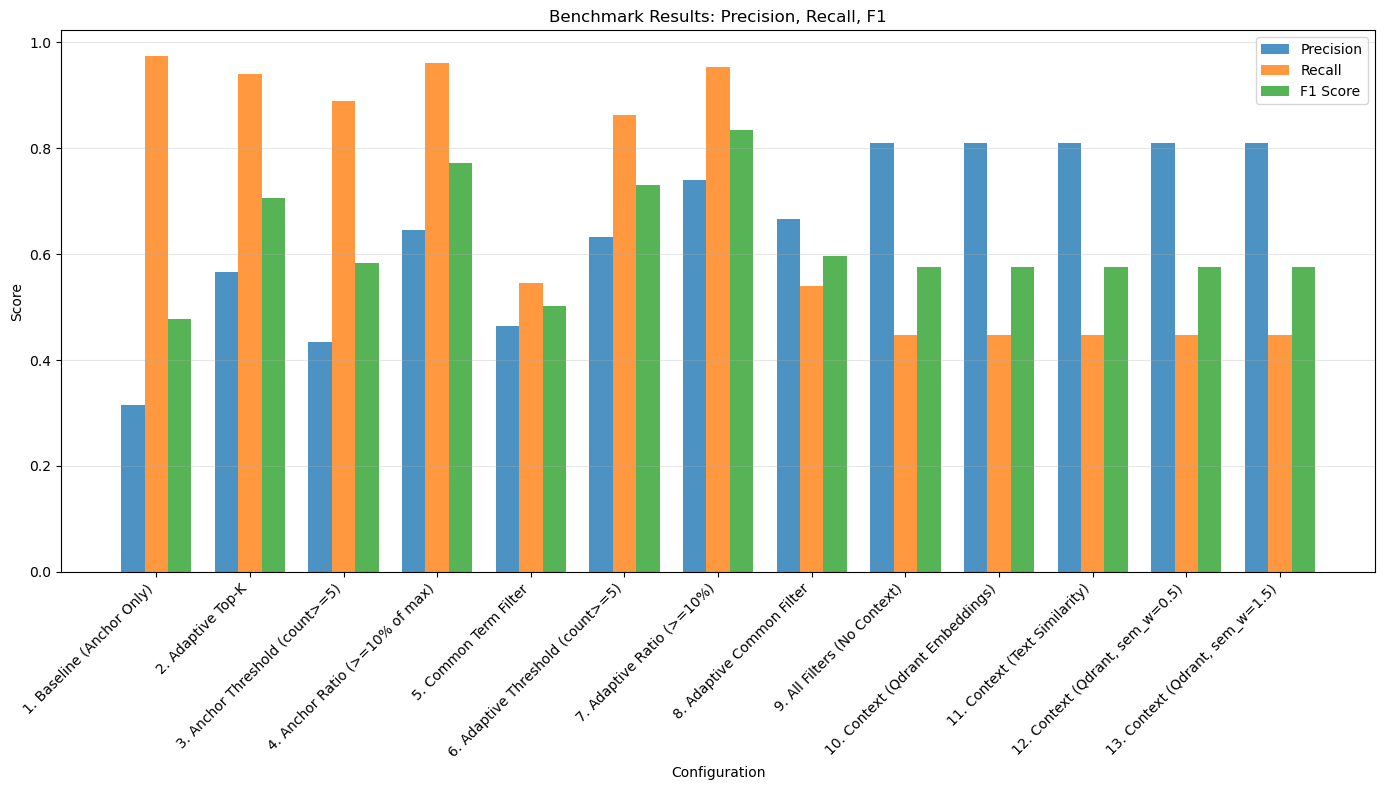

In [29]:
# ============================================================================
# VISUALIZATION
# ============================================================================

# Plot F1 scores
fig, ax = plt.subplots(figsize=(14, 8))

config_names = [r['config']['name'] for r in benchmark_results]
f1_scores = [r['eval_results']['f1'] for r in benchmark_results]
precisions = [r['eval_results']['precision'] for r in benchmark_results]
recalls = [r['eval_results']['recall'] for r in benchmark_results]

x = np.arange(len(config_names))
width = 0.25

ax.bar(x - width, precisions, width, label='Precision', alpha=0.8)
ax.bar(x, recalls, width, label='Recall', alpha=0.8)
ax.bar(x + width, f1_scores, width, label='F1 Score', alpha=0.8)

ax.set_xlabel('Configuration')
ax.set_ylabel('Score')
ax.set_title('Benchmark Results: Precision, Recall, F1')
ax.set_xticks(x)
ax.set_xticklabels([name.replace('+ ', '') for name in config_names], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('benchmark_results_full.png', dpi=150, bbox_inches='tight')
print("\n📊 Visualization saved to 'benchmark_results_full.png'")
plt.show()

📊 Context comparison saved to 'context_disambiguation_comparison.png'


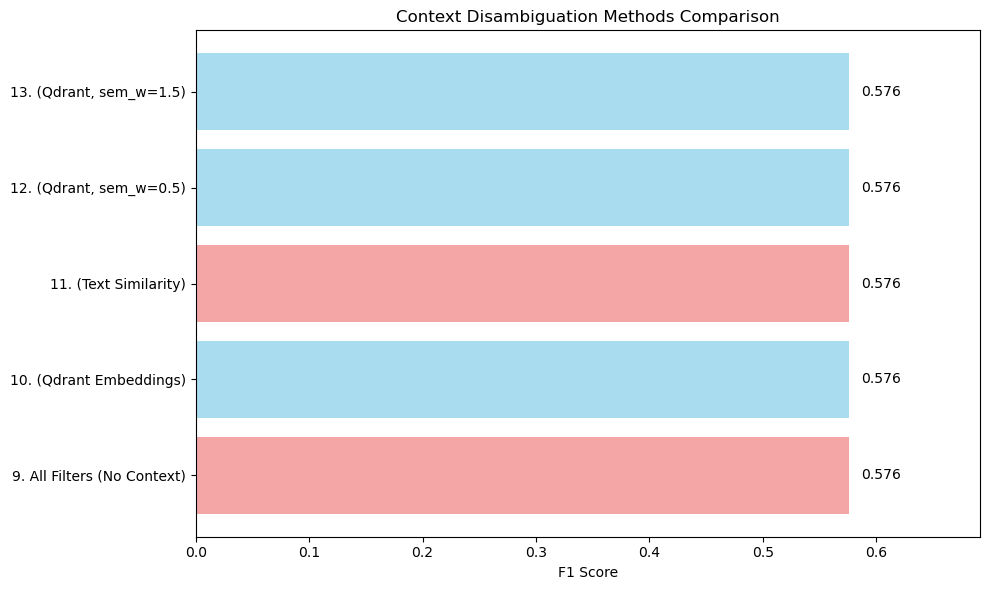

In [30]:
# Context disambiguation comparison
context_configs = [r for r in benchmark_results if 'Context' in r['config']['name']]
if context_configs:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    names = [r['config']['name'].replace('+ Context ', '').replace('Context ', '') for r in context_configs]
    f1s = [r['eval_results']['f1'] for r in context_configs]
    
    colors = ['skyblue' if 'Qdrant' in n else 'lightcoral' for n in names]
    bars = ax.barh(names, f1s, color=colors, alpha=0.7)
    
    ax.set_xlabel('F1 Score')
    ax.set_title('Context Disambiguation Methods Comparison')
    ax.set_xlim(0, max(f1s) * 1.2)
    
    for i, (bar, f1) in enumerate(zip(bars, f1s)):
        ax.text(f1 + 0.01, i, f'{f1:.3f}', va='center')
    
    plt.tight_layout()
    plt.savefig('context_disambiguation_comparison.png', dpi=150, bbox_inches='tight')
    print("📊 Context comparison saved to 'context_disambiguation_comparison.png'")
    plt.show()

In [ ]:
# Save all results
with open('comprehensive_benchmark_results.pkl', 'wb') as f:
    pickle.dump({
        'benchmark_results': benchmark_results,
        'best_config': best_config,
        'comparison_df': df_comparison,
        'test_data': test_data,
        'anchor_stats': anchor_stats
    }, f)

print("\n💾 All results saved to 'comprehensive_benchmark_results.pkl'")
print("✅ Script complete!")